In [47]:
"""
https://pytorch.org/examples/?utm_source=examples&utm_medium=examples-landing
"""
import lightning.pytorch as pl
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
from torch import utils
from torch.utils.data import Dataset, DataLoader, TensorDataset

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
print(torch.__version__)

Using cuda device
1.13.1


In [48]:
%pwd

'/www/test/pred'

In [49]:
def dataGen():
    np.random.seed(2)

    T = 20
    L = 1000
    N = 100

    x = np.empty((N, L), 'int64')
    x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
    data = np.sin(x / 1.0 / T).astype('float32')
    torch.save(data, open('traindata.pt', 'wb'))


# dataGen()
data = torch.load('traindata.pt')

input = torch.tensor(data[:, :-1], dtype=torch.float32, device=device)
target = torch.tensor(data[:, 1:], dtype=torch.float32, device=device)
print(input.shape, target.shape)

dataset = TensorDataset(input, target)

torch.Size([100, 999]) torch.Size([100, 999])


In [57]:
class MyDataModule(pl.LightningDataModule):
    def __init__(self, trainSet, batchSize: int):
        super().__init__()
        self.batchSize = batchSize
        self.trainSet, self.validSet, self.testsSet = utils.data.random_split(trainSet, [0.7, 0.2, 0.1])
        # print(dir(self.trainSet))
        print('dataset num', len(self.trainSet), len(self.validSet), len(self.testsSet))

    def train_dataloader(self):
        return DataLoader(self.trainSet, batch_size=self.batchSize, shuffle=False)

    def val_dataloader(self):
        return DataLoader(self.validSet, batch_size=self.batchSize, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.testsSet, batch_size=self.batchSize, shuffle=False)


class MyModel(pl.LightningModule):
    def __init__(self, lr: float, nGen: int = 100):
        super().__init__()
        self.save_hyperparameters("lr")
        self.nGen = nGen

        self.training_step_outputs = []
        self.metricA1 = torchmetrics.regression.MeanSquaredError(num_outputs=nGen)
        self.metricB1 = torchmetrics.regression.MeanSquaredError(num_outputs=nGen)
        self.metricC1 = torchmetrics.regression.MeanSquaredError(num_outputs=nGen)

        self.lstm1 = nn.LSTMCell(1, 20)
        self.lstm2 = nn.LSTMCell(20, 20)
        self.linear = nn.Linear(20, 1)

        self.criterion = nn.MSELoss()

    def forward(self, x, future=0):
        outputs = []
        h0 = torch.zeros(x.size(0), 20, dtype=torch.float32, device=device)
        c0 = torch.zeros(x.size(0), 20, dtype=torch.float32, device=device)
        h1 = torch.zeros(x.size(0), 20, dtype=torch.float32, device=device)
        c1 = torch.zeros(x.size(0), 20, dtype=torch.float32, device=device)

        for input_t in x.split(1, dim=1):
            h0, c0 = self.lstm1(input_t, (h0, c0))
            h1, c1 = self.lstm2(h0, (h1, c1))
            output = self.linear(h1)
            outputs += [output]
        for i in range(future):  # if we should predict the future
            h0, c0 = self.lstm1(output, (h0, c0))
            h1, c1 = self.lstm2(h0, (h1, c1))
            output = self.linear(h1)
            outputs += [output]

        outputs = torch.cat(outputs, dim=1)
        # print('forward.outputs', outputs.shape)
        return outputs

    def configure_optimizers(self):
        optimizer = optim.LBFGS(self.parameters(), lr=0.8)
        return optimizer

    def training_step(self, batch, batch_idx):
        inputs, target = batch
        outputs = self.forward(inputs)
        loss = nn.MSELoss()(outputs, target)

        # self.metricA1.update(outputs, target)
        self.log("a/1", loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, target = batch
        outputs = self.forward(inputs, future=self.nGen)[:, -self.nGen:]
        loss = nn.MSELoss()(outputs, target)
        # print("in out target .shape", inputs.shape, outputs.shape, target.shape, self.nGen)

        self.metricB1.update(outputs, target)
        self.log("b/1", loss, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        inputs, target = batch
        outputs = self.forward(inputs, future=self.nGen)[:, -self.nGen:]
        loss = nn.MSELoss()(outputs, target)

        self.metricC1.update(outputs, target)
        self.log("c/1", loss, on_step=False, on_epoch=True)

    # def on_train_epoch_end(self):
    #     print('epoch.{}.train.loss {:.6f}'.format(self.current_epoch, torch.mean(self.metricA1.compute()).item()))
    #     self.metricA1.reset()

    def on_validation_epoch_end(self):
        print('epoch.{}.valid.loss {:.6f}'.format(self.current_epoch, torch.mean(self.metricB1.compute()).item()))
        self.metricB1.reset()

    def on_test_epoch_end(self):
        print('epoch.{}.test..loss {:.6f}'.format(self.current_epoch, torch.mean(self.metricC1.compute()).item()))
        self.metricC1.reset()


dm = MyDataModule(dataset, 200)

dataset num 70 20 10


In [58]:
model = MyModel(lr=0.1, nGen=999)

logger = None
trainer = pl.Trainer(logger=logger, max_epochs=10, enable_progress_bar=False, enable_checkpointing=False)
trainer.fit(model, datamodule=dm)
trainer.test(model, datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | metricA1  | MeanSquaredError | 0     
1 | metricB1  | MeanSquaredError | 0     
2 | metricC1  | MeanSquaredError | 0     
3 | lstm1     | LSTMCell         | 1.8 K 
4 | lstm2     | LSTMCell         | 3.4 K 
5 | linear    | Linear           | 21    
6 | criterion | MSELoss          | 0     
-----------------------------------------------
5.2 K     Trainable params
0         Non-trainable params
5.2 K     Total params
0.021     Total estimated model params size (MB)


epoch.0.valid.loss 0.502933
epoch.0.valid.loss 1.231642
epoch.1.valid.loss 0.526298
epoch.2.valid.loss 0.816305
epoch.3.valid.loss 0.744742
epoch.4.valid.loss 0.812875
epoch.5.valid.loss 0.565731
epoch.6.valid.loss 0.025020
epoch.7.valid.loss 0.018927
epoch.8.valid.loss 0.018927


`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


epoch.9.valid.loss 0.018927
epoch.10.test..loss 0.019426


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            c/1            │   0.019426070153713226    │
└───────────────────────────┴───────────────────────────┘

[{'c/1': 0.019426070153713226}]

xi, yi torch.Size([999]) torch.Size([1499])


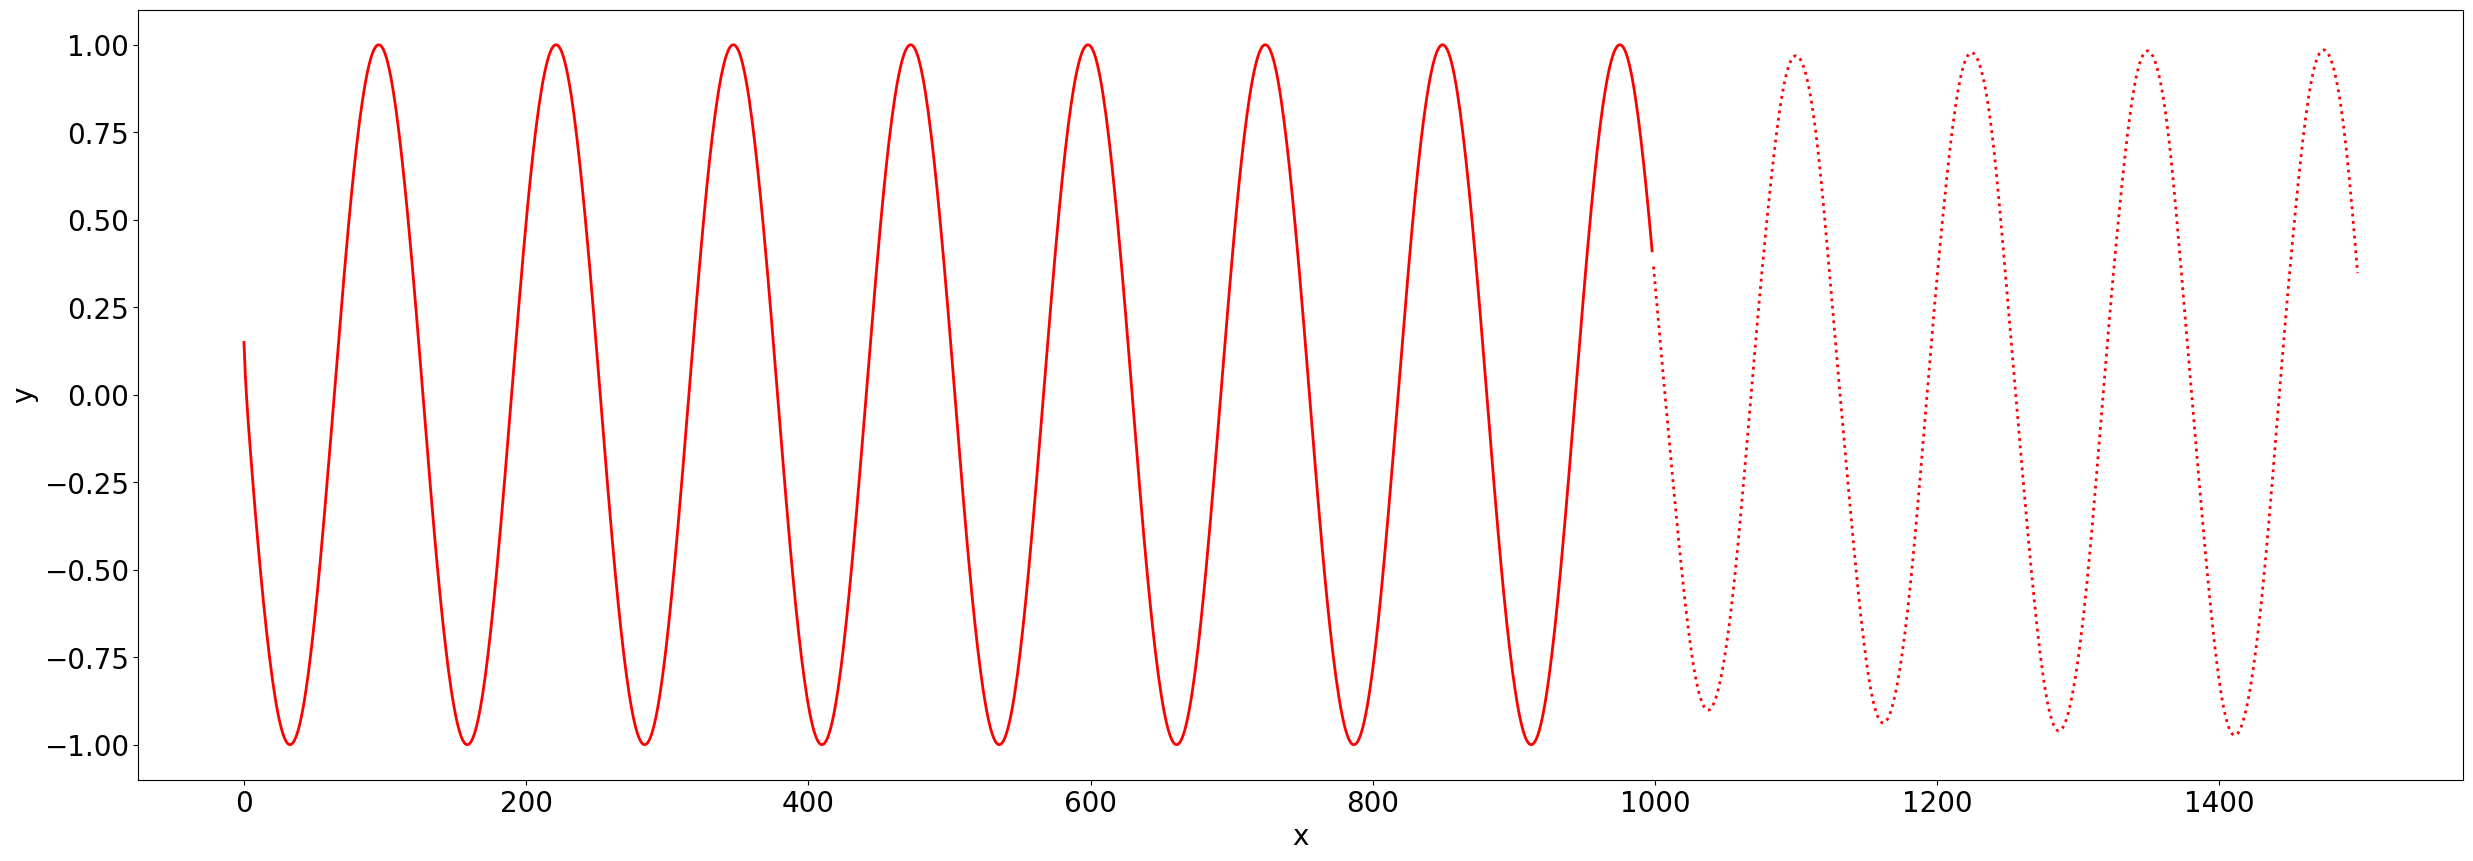

In [63]:
plt.figure(figsize=(30, 10))
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

model.cuda()
model.eval()


def draw(row, color):
    xi: torch.Tensor = row[0]
    xd = xi.size(0)  # 999

    nGen = 500
    yi = model(xi.unsqueeze(0), nGen).cpu().detach()[0]
    print('xi, yi', xi.shape, yi.shape)
    plt.plot(np.arange(xd), yi[:xd], color, linewidth=2.0)
    plt.plot(np.arange(xd, xd + nGen), yi[xd:], color + ':', linewidth=2.0)


draw(dataset[0], 'r')
# draw(dataset[1], demoY[1], 'g')
# draw(dataset[2], demoY[2], 'b')